Device being used: cuda
{'train': 5482, 'test': 1723}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

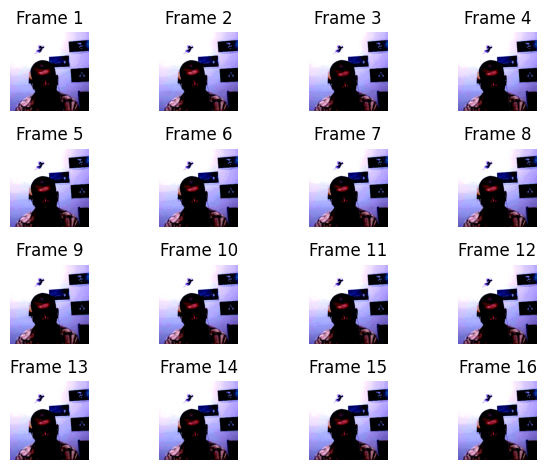


 Input Shape    torch.Size([6, 16, 3, 224, 224]) 
 Output Shape    torch.Size([6, 4]) 
 Label Shape   torch.Size([6])


In [17]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ResTCN import ResTCN
from utils import get_dataloader
import warnings
warnings.filterwarnings("ignore")

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_model.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
            
            for i in range(16):
                inputs = inputs.cpu()
                plt.subplot(4, 4, i+1)  # Create subplot for each frame
                plt.imshow(inputs[1, i, :, :].permute(1,2,0), cmap='gray')  # Plot the frame
                plt.axis('off')  # Turn off axis
                plt.title(f'Frame {i+1}')  # Add title
            plt.tight_layout()  # Adjust layout
            plt.show() 
            break
        break

print("\n Input Shape   ",inputs.shape,"\n Output Shape   ",outputs.shape,"\n Label Shape  ",labels.shape)

In [1]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np

from ResTCN import ResTCN
from utils import get_dataloader

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_model.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in tqdm(dataloader[phase]):
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            try:
                preds = torch.max(softmax(outputs), dim=1)[1]  # Fix here
                # print('HI')
            except Exception as e:
                print (e)
                continue
            

            y_trues = np.append(y_trues, labels.data.cpu().numpy())
            y_preds = np.append(y_preds, preds.cpu())
            
            
        # if phase == 'train':
        #     scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        val_losses.append(epoch_loss)

        print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
            phase, 0 + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
        print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
        print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))



c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device being used: cuda
{'train': 5482, 'test': 1723}


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0

Dimension out of range (expected to be in range of [-1, 0], but got 1)
[test] Epoch: 1/25 Loss: 1.1734971105706464 LR: [0.001]

confusion matrix
[[  0   0   3   1]
 [  0   6  33  42]
 [  0   6 298 556]
 [  0   6 222 549]]

accuracy	0.49535423925667826


In [2]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np

from ResTCN import ResTCN
from utils import get_dataloader

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_model_weighted.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in tqdm(dataloader[phase]):
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            try:
                preds = torch.max(softmax(outputs), dim=1)[1]  # Fix here
                # print('HI')
            except Exception as e:
                print (e)
                continue
            

            y_trues = np.append(y_trues, labels.data.cpu().numpy())
            y_preds = np.append(y_preds, preds.cpu())
            
            
        # if phase == 'train':
        #     scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        val_losses.append(epoch_loss)

        print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
            phase, 0 + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
        print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
        print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))



Device being used: cuda


{'train': 5482, 'test': 1723}


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0

Dimension out of range (expected to be in range of [-1, 0], but got 1)
[test] Epoch: 1/25 Loss: 1.0123746323848422 LR: [0.001]

confusion matrix
[[  0   2   2   0]
 [  2  12  25  42]
 [ 24  18 224 594]
 [ 31  15 159 572]]

accuracy	0.4692218350754936


In [3]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np

from ResTCN import ResTCN
from utils import get_dataloader

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_model_aug_weighted.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in tqdm(dataloader[phase]):
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            try:
                preds = torch.max(softmax(outputs), dim=1)[1]  # Fix here
                # print('HI')
            except Exception as e:
                print (e)
                continue
            

            y_trues = np.append(y_trues, labels.data.cpu().numpy())
            y_preds = np.append(y_preds, preds.cpu())
            
            
        # if phase == 'train':
        #     scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        val_losses.append(epoch_loss)

        print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
            phase, 0 + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
        print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
        print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))



Device being used: cuda
{'train': 5482, 'test': 1723}


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0

Dimension out of range (expected to be in range of [-1, 0], but got 1)
[test] Epoch: 1/25 Loss: nan LR: [0.001]

confusion matrix
[[  4   0   0   0]
 [ 81   0   0   0]
 [860   0   0   0]
 [777   0   0   0]]

accuracy	0.0023228803716608595


In [4]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np

from ResTCN import ResTCN
from utils import get_dataloader

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_mod_model_weighted.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in tqdm(dataloader[phase]):
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            try:
                preds = torch.max(softmax(outputs), dim=1)[1]  # Fix here
                # print('HI')
            except Exception as e:
                print (e)
                continue
            

            y_trues = np.append(y_trues, labels.data.cpu().numpy())
            y_preds = np.append(y_preds, preds.cpu())
            
            
        # if phase == 'train':
        #     scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        val_losses.append(epoch_loss)

        print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
            phase, 0 + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
        print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
        print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))



Device being used: cuda
{'train': 5482, 'test': 1723}


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0

Dimension out of range (expected to be in range of [-1, 0], but got 1)
[test] Epoch: 1/25 Loss: 1.2612531442698944 LR: [0.001]

confusion matrix
[[  0   0   1   3]
 [  0   5  25  51]
 [  0   7 319 534]
 [  0   6 229 542]]

accuracy	0.502903600464576


In [5]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pickle
import numpy as np

from ResTCN import ResTCN
from utils import get_dataloader

os.chdir(r"F:\RESTCN_CODE")

torch.manual_seed(0)
num_epochs = 25
batch_size = 6
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


# dataloader = get_dataloader(batch_size,
#                             'train.csv',
#                             os.path.join(os.getcwd(), 'images_train'),
#                             'test.csv',
#                             os.path.join(os.getcwd(), 'images_test'))
dataloader = get_dataloader(batch_size,
                            'csv\\train.csv',
                            os.getcwd(),
                            'csv\\test.csv',
                            os.getcwd())

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train','test']}
print(dataset_sizes, flush=True) # OUTPUT: {'train': 5482, 'test': 1784}


model = ResTCN().to(device)
model.load_state_dict(torch.load(r"resTCN_mod_model_weighted-1.pth"))

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=50, gamma=.1)

criterion = nn.CrossEntropyLoss().to(device)
softmax = nn.Softmax()

train_losses = []
val_losses = []
running_loss=0
for phase in ['test']:
        model.eval()
        running_loss = .0
        y_trues = np.empty([0])
        y_preds = np.empty([0])

        for inputs, labels in tqdm(dataloader[phase]):
            inputs = inputs.to(device)
            labels = labels.long().squeeze().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            try:
                preds = torch.max(softmax(outputs), dim=1)[1]  # Fix here
                # print('HI')
            except Exception as e:
                print (e)
                continue
            

            y_trues = np.append(y_trues, labels.data.cpu().numpy())
            y_preds = np.append(y_preds, preds.cpu())
            
            
        # if phase == 'train':
        #     scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        val_losses.append(epoch_loss)

        print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
            phase, 0 + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
        print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
        print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))



Device being used: cuda
{'train': 5482, 'test': 1723}


c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manvendra Nema\anaconda3\envs\vercil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0

Dimension out of range (expected to be in range of [-1, 0], but got 1)
[test] Epoch: 1/25 Loss: 1.3318707411606092 LR: [0.001]

confusion matrix
[[  0   0   2   2]
 [  0   0  35  46]
 [  0   0 332 528]
 [  0   0 246 531]]

accuracy	0.5011614401858304
